In [1]:
import os
os.chdir("../")
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.factory.config_factory import cfg, show_configs
from src.factory.data_factory import DataFactory
from src.factory.data_format_factory import DataFormatFactory
from src.factory.transform_factory import TransformFactory
from src.factory.loader_factory import LoaderFactory
from src.base_data import BaseData
from tools.logger import setup_logger
logger = setup_logger("./external/")

In [2]:
cfg.NUM_WORKERS = 1
cfg.DB.PATH = "/media/allen/mass/DB"
cfg.DB.DATA = "prw ethz coco"
cfg.DB.DATA_FORMAT = "coco"
cfg.DB.TARGET_FORMAT = "centernet"
cfg.DB.LOADER = "coco"
cfg.DB.USE_TRAIN = True
cfg.DB.USE_TEST = False
cfg.INPUT.SIZE = (512, 512)
cfg.INPUT.TRAIN_BS = 1
cfg.MODEL.STRIDES = [4]
cfg.DB.TRAIN_TRANSFORM = "RandScale Tensorize"
cfg.DB.TEST_TRANSFORM = "Resize Tensorize"
cfg.COCO.TARGET = "person"


In [3]:
data_names = cfg.DB.DATA.split(" ")
handles = []
indice = []
pids = []
offset = 0
for idx, name in enumerate(data_names[:-1]):
    data = DataFactory.produce(cfg, data_name=name)
    handles.append(data.train['handle'])
    pids.append(data.train['pid'])
    for img_id, img_path in data.train['indice']:
        indice.append((img_id, img_path, idx, offset))
    offset += (max(list(data.train['pid'].values())) + 1)

_data = BaseData()
_data.train['handle'] = handles
_data.train['indice'] = indice
_data.train['pid'] = pids
_data.train['strides'] = cfg.MODEL.STRIDES
_data.train['num_classes'] = offset
cfg.DB.NUM_CLASSES = offset

trans = TransformFactory.produce(cfg, cfg.DB.TRAIN_TRANSFORM)
dataset = DataFormatFactory.produce(cfg, _data.train, trans)

TypeError: produce() got an unexpected keyword argument 'data_name'

In [4]:
batch = dataset[0]

In [3]:
loader = LoaderFactory.produce(cfg)


loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
2020-04-14 17:15:31,523 8772 coco.py INFO: => PRW TRAIN is loaded
2020-04-14 17:15:31,524 8772 coco.py INFO:   Dataset statistics:
2020-04-14 17:15:31,524 8772 coco.py INFO:   -----------------------------
2020-04-14 17:15:31,525 8772 coco.py INFO:   subset   | #id     | # images
2020-04-14 17:15:31,527 8772 coco.py INFO:   -----------------------------
2020-04-14 17:15:31,528 8772 coco.py INFO:   train    |     933 |    11792
2020-04-14 17:15:31,529 8772 coco.py INFO:   -----------------------------
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
2020-04-14 17:15:31,687 8772 coco.py INFO: => ETHZ TRAIN is loaded
2020-04-14 17:15:31,687 8772 coco.py INFO:   Dataset statistics:
2020-04-14 17:15:31,688 8772 coco.py INFO:   -----------------------------
2020-04-14 17:15:31,689 8772 coco.py INFO:   subset   | #id     | # images
2020-04-14 17:15:31,690 8772 coco.py INFO:   -

In [11]:
import pycocotools.coco as coco
import json
import os
import os.path as osp
from PIL import Image
from tqdm import tqdm
import numpy as np
import shutil
import cv2

from tools.centernet_utils import centernet_det_decode, centernet_det_post_process
from tools.oracle_utils import gen_oracle_map
from tools.image import get_affine_transform

In [5]:
batch = next(iter(loader['train']))
batch['bboxes']

[tensor([[0.9980, 0.4808, 0.9980, 0.6346],
         [0.9980, 0.4573, 0.9980, 0.5887],
         [0.4135, 0.5043, 0.5235, 0.8579]])]

In [9]:
batch.keys()

dict_keys([(128, 128), 'inp', 'img_id', 'bboxes', 'c', 's'])

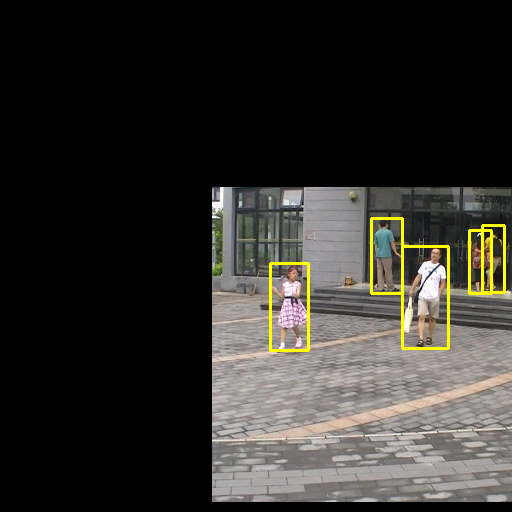

In [12]:
batch = next(iter(loader['train']))
batch['bboxes']
bboxes = np.vstack(batch['bboxes'])
bboxes[:, [0,2]] *= 512
bboxes[:, [1,3]] *= 512
np_img = (batch['inp']*255).squeeze().permute(1,2,0).numpy().astype(np.uint8)
np_img = cv2.resize(np_img, (512,512))
Image.fromarray(np_img)
for b in bboxes:
    x1, y1, x2, y2 = b
    cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
Image.fromarray(np_img)

In [14]:
hm = batch[(128,128)]['hm']
wh = torch.from_numpy(
        gen_oracle_map(
            batch[(128,128)]['wh'].detach().cpu().numpy(), 
            batch[(128,128)]['ind'].detach().cpu().numpy(), 
            batch['inp'].shape[3] // 4, 
            batch['inp'].shape[2] // 4,
        ))
reg = torch.from_numpy(
        gen_oracle_map(
            batch[(128,128)]['reg'].detach().cpu().numpy(), 
            batch[(128,128)]['ind'].detach().cpu().numpy(), 
            batch['inp'].shape[3] // 4, 
            batch['inp'].shape[2] // 4
        ))
dets = centernet_det_decode(heat=hm, wh=wh, reg=reg)
dets = dets.detach().cpu().numpy().reshape(1, -1, dets.shape[1])
final = centernet_det_post_process(
    dets=dets, 
    c=batch['c'].numpy(), 
    s=batch['s'].numpy(), 
    h=hm.shape[2], 
    w=hm.shape[3], 
    num_classes=hm.shape[1]
)

In [8]:
final[0][1][0]

[315.0, 168.0, 373.5, 317.5, 1.0]

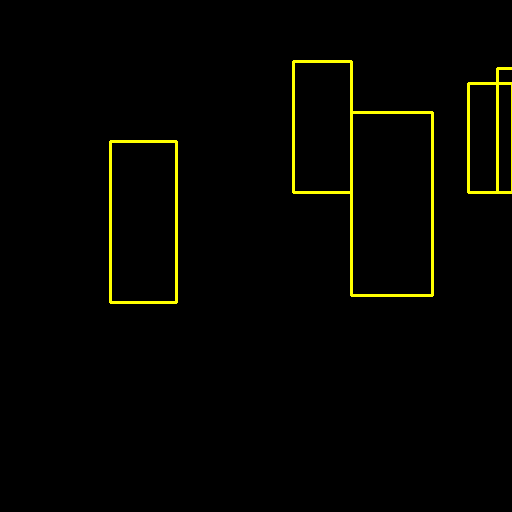

In [15]:
# np_img = (batch['inp']*255).squeeze().permute(1,2,0).numpy().astype(np.uint8)
# np_img = cv2.resize(np_img, (512,512))
Image.fromarray(np_img)
for b in final[0][1]:
    x1, y1, x2, y2, score = b
    if score > 0.5:
        cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
Image.fromarray(np_img)

In [18]:
a = torch.rand(1).squeeze()

In [21]:
torch.Tensor([a,a,a])

tensor([0.9199, 0.9199, 0.9199])